In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../src/")
import data_preparation as dp
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.linear_model import LinearRegression
import warnings
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings("ignore", category=FutureWarning)

# Import des données

In [77]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

/var/folders/12/33kq22951gn7jfpz3d32v_qc0000gn/T/ipykernel_7438/176984250.py:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("../data/train.csv")
/var/folders/12/33kq22951gn7jfpz3d32v_qc0000gn/T/ipykernel_7438/176984250.py:2: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv("../data/test.csv")


In [78]:
preprocess = dp.DataPreparation(train, test)

In [79]:
train_clean, test_clean = preprocess.prepare_data()

Valeurs manquantes du train supprimées ✅
Valeurs manquantes du test supprimées ✅
Valeurs manquantes numériques imputées ✅
Valeurs manquantes catégorielles imputées ✅


In [87]:
X_train = train_clean.drop(columns = ["Ewltp (g/km)"])
y_train = train_clean["Ewltp (g/km)"]

In [88]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [93]:
numericals = train_clean.select_dtypes(exclude='object').columns.to_list()
categoricals = train_clean.select_dtypes(include='object').columns.to_list()

numericals.remove('ID')
numericals.remove('date')

# Choix des variables à inclure

<Axes: >

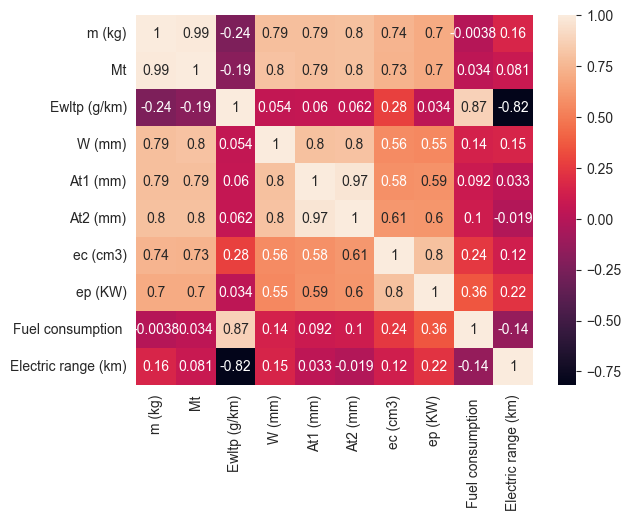

In [94]:
y_corr = train[numericals].corr()
sns.heatmap(y_corr, annot=True)

In [95]:
correlation_vector = train[numericals].corr()["Ewltp (g/km)"][:]
correlation_vector = np.abs(correlation_vector)
correlation_vector = correlation_vector.sort_values(ascending=False)[1:]

In [96]:
var_explicatives = correlation_vector.index[:4].to_list()

# Modélisation

In [97]:
reg = LinearRegression().fit(X_train[var_explicatives], y_train)

In [98]:
pred = reg.predict(X_val[var_explicatives])

In [99]:
mae = mean_absolute_error(y_val, pred)

In [100]:
mae

60.449540733261614

# Test

In [102]:
test_pred = reg.predict(test_clean[var_explicatives])

In [103]:
sub = test[["ID", 'ec (cm3)']]

In [104]:
sub["Ewltp (g/km)"] = test_pred

/var/folders/12/33kq22951gn7jfpz3d32v_qc0000gn/T/ipykernel_7438/2566286789.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub["Ewltp (g/km)"] = test_pred


In [105]:
sub

,ID,ec (cm3),Ewltp (g/km)
0,8000000,1598.0,122.734099
1,8000001,998.0,355.159238
2,8000002,998.0,355.159238
3,8000003,998.0,355.159238
4,8000004,998.0,355.159238
...,...,...,...
1892908,9892908,1598.0,135.912958
1892909,9892909,NaN,-11.179263
1892910,9892910,NaN,-28.293299
1892911,9892911,1490.0,369.531515


In [106]:
sub.drop(columns=['ec (cm3)'], inplace = True)

/var/folders/12/33kq22951gn7jfpz3d32v_qc0000gn/T/ipykernel_7438/3581638567.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub.drop(columns=['ec (cm3)'], inplace = True)


In [107]:
sub.to_csv("../data/sample_submission2.csv", index=False)

In [108]:
len(sub)

1892913

# Correlation catégorielle

In [3]:
train = pd.read_csv("../data/train_clean.csv")
test = pd.read_csv("../data/test_clean.csv")

X_train = train.drop(columns=["Ewltp (g/km)"])
y_train = train["Ewltp (g/km)"]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

numericals = train.select_dtypes(exclude='object').columns.to_list()
categoricals = train.select_dtypes(include='object').columns.to_list()

numericals.remove('ID')

In [14]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
train.rename(columns={"Ewltp (g/km)": "Ewltp_g_per_km"}, inplace=True)
#categoricals.remove("Date of registration")

for col in categoricals: 
    # Fit le modèle
    model = ols(f'Ewltp_g_per_km ~ {col}', data=train.iloc[:50000,:]).fit()
    
    # Exécute ANOVA
    aov_table = sm.stats.anova_lm(model, typ=2)  # typ=2 donne l'ANOVA à deux voies
    eta_squared = aov_table['sum_sq'][0] / sum(aov_table['sum_sq'])
    print("eta :", eta_squared)
    print(aov_table)

eta : 0.10529690219866984
                sum_sq       df           F  PR(>F)
Country   9.712036e+07      7.0  840.502724     0.0
Residual  8.252274e+08  49992.0         NaN     NaN
eta : 0.9956275653382332
                sum_sq       df            F  PR(>F)
VFN       9.183148e+08   1622.0  6791.436851     0.0
Residual  4.032905e+06  48377.0          NaN     NaN
eta : 0.3309337597329461
                sum_sq       df            F  PR(>F)
Mp        3.052360e+08      9.0  2747.341104     0.0
Residual  6.171117e+08  49990.0          NaN     NaN
eta : 0.38158971005992637
                sum_sq       df         F  PR(>F)
Mh        3.519584e+08     42.0  733.9509     0.0
Residual  5.703893e+08  49957.0       NaN     NaN
eta : 0.38158971006470255
                sum_sq       df           F  PR(>F)
Man       3.519584e+08     42.0  733.950901     0.0
Residual  5.703893e+08  49957.0         NaN     NaN
eta : 0.7626575951706561
                sum_sq       df           F  PR(>F)
Tan       7.034

In [11]:
eta_squared = aov_table['sum_sq'][0] / sum(aov_table['sum_sq'])

In [12]:
eta_squared

0.42534683952880203

In [ ]:
formula = 'Ewltp_g_per_km ~ ' + ' + '.join(['C(' + var + ')' for var in categoricals])
model = ols(formula, data=train).fit()
aov_table = sm.stats.anova_lm(model, typ=2)  # typ=2 donne l'ANOVA à deux voies
print(aov_table)

In [19]:
eta = [aov_table['sum_sq'][i] / sum(aov_table['sum_sq']) for i in range(len(categoricals))]

In [22]:
for i in range(len(categoricals)):
    print(f'{categoricals[i]} : {round(eta[i], 2)*100}')

Country : 0.0
VFN : 19.0
Mp : 1.0
Mh : 3.0
Man : 3.0
Tan : 5.0
T : 4.0
Va : 18.0
Ve : 20.0
Mk : 2.0
Cn : 12.0
Ct : 1.0
Cr : 1.0
Ft : 3.0
Fm : 8.0
date : 0.0
